In [1]:
!pip install optuna nltk torchinfo safetensors -q
!pip install transformers==4.56.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 58.0 MB/s eta 0:00:00


In [2]:
import gdown

!gdown --folder https://drive.google.com/drive/folders/15afW9pnFJ42oIDEhAm-N30ZRDA-_g93u?usp=drive_link -q
!gdown --folder https://drive.google.com/drive/folders/1_Qjbb2cAa_eW_WmjmVwTfEufwfhDjUIh?usp=drive_link -q

*****
## Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import nltk
import json
import copy
import random

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

import torch
import optuna
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding, get_linear_schedule_with_warmup

from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

from safetensors.torch import save_file, load_file

# set working directory
import os
# os.chdir(r'd:\Programing\Youtube_Comment_Sentiments_&_Type_Analysis')
os.chdir(f'/content')

import warnings
warnings.filterwarnings('ignore')

*****
## Dataset Loading

In [4]:
train_df = pd.read_csv('./data/train_dataset.csv')
test_df = pd.read_csv('./data/test_dataset.csv')
valid_df = pd.read_csv('./data/valid_dataset.csv')
sentiment_df = pd.read_csv('./data/evaluation_dataset.csv')

In [5]:
train_df.shape, test_df.shape, valid_df.shape, sentiment_df.shape

((15393, 4), (1925, 4), (1924, 4), (8842, 4))

In [6]:
train_df.columns, sentiment_df.columns

(Index(['comment_v1', 'comment_v2', 'type', 'sentiment'], dtype='object'),
 Index(['clean_comment_v1', 'clean_comment_v2', 'sentiment', 'type'], dtype='object'))

In [7]:
train_x = train_df['comment_v1']
train_y = train_df[['sentiment', 'type']]

test_x = test_df['comment_v1']
test_y = test_df[['sentiment', 'type']]

valid_x = valid_df['comment_v1']
valid_y = valid_df[['sentiment', 'type']]

sentiment_x = sentiment_df['clean_comment_v1']
sentiment_y = sentiment_df[['sentiment', 'type']]

*****
## Model and Dataset Class

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, x, y, tokenizer, max_len=128):
        self.x = x.tolist()
        self.y_sentiment = torch.LongTensor(y['sentiment'].values)
        self.y_type = torch.LongTensor(y['type'].values)
        self.tokenizer = tokenizer
        self.max_len=max_len

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = str(self.x[idx])
        encode = self.tokenizer(
            x,
            return_attention_mask=True,
            truncation=True,
            max_length=max_len,
            return_tensors=None,
        )

        return {
            'input_ids': encode['input_ids'],
            'attention_mask': encode['attention_mask'],
            'sentiment_label': self.y_sentiment[idx],
            'type_label': self.y_type[idx]
        }

In [9]:
class SentimentBERT(nn.Module):
    def __init__ (self, model, sentiment_out, type_out, dropout_rate=0.4):
        super(SentimentBERT, self).__init__()
        # bert as base model & feature extractor
        self.model = model
        hidden_dim = self.model.config.hidden_size

        self.dropout = nn.Dropout(dropout_rate)

        # classifiers head
        self.sentiment = nn.Linear(hidden_dim, sentiment_out)
        self.type_ = nn.Linear(hidden_dim, type_out)

    def forward(self, ids, attention_mask):
        x = self.model(input_ids=ids, attention_mask=attention_mask)
        x = x.last_hidden_state[:, 0, :] # extract [batch_size, hidden_state]

        # x = self.dropout(x)

        sentiment_out = self.sentiment(x)
        type_out = self.type_(x)

        return sentiment_out, type_out

*****
## Training Functions

In [10]:
def train_eval_loop(model, data_loader, epoch, optimizer, scheduler=None, is_train=False, device='cuda'):
    losses = 0.0
    correct_sentiment = 0
    correct_type = 0

    criterion = nn.CrossEntropyLoss().to(device)

    # set mode (train / eval)
    model.train() if is_train else model.eval()
    msg = f"Trainining Epoch - {epoch + 1}" if is_train else f"Validation Epoch - {epoch + 1}"
    loop = tqdm(data_loader, leave=True, desc=msg)
    for batch in loop:
        ids, a_m, y_sentiment, y_type = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['sentiment_label'].to(device), batch['type_label'].to(device)

        # forward pass
        y_sen, y_ty = model(ids, a_m)

        # calculate loss
        # print("loss_sentiment:: ", y_sen, y_sentiment)
        loss_sentiment = criterion(y_sen, y_sentiment)
        # print("loss_type:: ", y_ty, y_type)
        loss_type = criterion(y_ty, y_type)

        loss = loss_sentiment + loss_type

        if is_train:
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update grad
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

        # calculate total losses and accuracy
        losses += loss.item()
        _, pred_sentiment = torch.max(y_sen, 1)
        _, pred_type = torch.max(y_ty, 1)

        correct_sentiment += (pred_sentiment == y_sentiment).sum().item()
        correct_type += (pred_type == y_type).sum().item()

        loop.set_postfix(loss=loss.item())

    avg_loss = losses / len(data_loader)
    avg_acc_sentiment = correct_sentiment / len(data_loader.dataset)
    avg_acc_type = correct_type / len(data_loader.dataset)

    return avg_loss, avg_acc_sentiment, avg_acc_type, ((avg_acc_sentiment+avg_acc_type) / 2)


In [11]:
def train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        n_epochs,
        device='cuda',
        patience=3, # wait for next 10 epoch to stop training and return the best state model
        is_monitor=False, # it will be true only for training
        is_stopping=False # true if we want to stop training early if no better state found
    ):

    # initialize the tensorboard
    writer = SummaryWriter('runs/training_logs') if is_monitor else None

    # total training losses and accuracy
    train_losses = []
    train_acc_sentiments = []
    train_acc_types = []
    train_acc_avgs = []

    # total validation losses and accuracy
    val_losses = []
    val_acc_sentiments = []
    val_acc_types = []
    val_acc_avgs = []

    best_model_state = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    counter = 0

    # training loop
    for epoch in range(n_epochs):
        # training
        train_loss, train_acc_sentiment, train_acc_type, train_acc_avg = train_eval_loop(
            model,
            train_loader,
            epoch,
            optimizer,
            scheduler,
            is_train=True,
            device=device
        )

        # storing the results
        train_losses.append(train_loss)
        train_acc_sentiments.append(train_acc_sentiment)
        train_acc_types.append(train_acc_type)
        train_acc_avgs.append(train_acc_avg)

        # valudation
        val_loss, val_acc_sentiment, val_acc_type, val_acc_avg = train_eval_loop(
            model,
            val_loader,
            epoch,
            optimizer,
            is_train=False,
            device=device
        )

        # storing the vvalidation results
        val_losses.append(val_loss)
        val_acc_sentiments.append(val_acc_sentiment)
        val_acc_types.append(val_acc_type)
        val_acc_avgs.append(val_acc_avg)


        print(f"\n        [INFO] Epoch: {epoch+1}/{n_epochs}, "
              f"Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, Train Acc: {train_acc_avg:.4f}, Val Acc: {val_acc_avg:.4f}\n")

        # tensorboard logging
        if writer is not None:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)

            writer.add_scalar('Accuracy/train_sentiment', train_acc_sentiment, epoch)
            writer.add_scalar('Accuracy/train_type', train_acc_type, epoch)
            writer.add_scalar('Accuracy/train_avg', train_acc_avg, epoch)

            writer.add_scalar('Accuracy/val_sentiment', val_acc_sentiment, epoch)
            writer.add_scalar('Accuracy/val_type', val_acc_type, epoch)
            writer.add_scalar('Accuracy/val_avg', val_acc_avg, epoch)

        # setup the scheduler based on validation loss
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if is_stopping:
                if counter >= patience and epoch > 50:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if writer is not None:
            writer.flush()

    model.load_state_dict(best_model_state)   # loading the best model states
    model.to(device)

    if writer is not None:
        writer.close()

    return model, {
        'train_losses': train_losses,
        'train_acc_sentiments': train_acc_sentiments,
        'train_acc_types': train_acc_types,
        'train_acc_avgs': train_acc_avgs,
        'val_losses': val_losses,
        'val_acc_sentiments': val_acc_sentiments,
        'val_acc_types': val_acc_types,
        'val_acc_avgs': val_acc_avgs
    }

*****
## Training

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name()}")
    print(f"Number of Device :{torch.cuda.device_count()}")
else:
    print("Device: CPU")

Device: Tesla T4
Number of Device :1


In [53]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
base_model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-base")

In [14]:
train_dataset = SentimentDataset(train_x, train_y, tokenizer)
val_dataset = SentimentDataset(valid_x, valid_y, tokenizer)
test_data = SentimentDataset(test_x, test_y, tokenizer)
sentiment_data = SentimentDataset(sentiment_x, sentiment_y, tokenizer)

sentiment_out = train_y['sentiment'].nunique()
type_out = train_y['type'].nunique()

print(f"Number of Sentiment class: {sentiment_out}")
print(f"Number of Type class: {type_out}")

max_len=128
batch_size = 16
learning_rate = 2e-5
weight_decay = 0.02
dropout_rate = 0.5
eps = 1e-8
epochs = 6

Number of Sentiment class: 3
Number of Type class: 5


In [15]:
model = SentimentBERT(
    model=base_model,
    sentiment_out=sentiment_out,
    type_out=type_out,
    dropout_rate=dropout_rate
).to(device)

collator = DataCollatorWithPadding(tokenizer=tokenizer)

# model training with best parameters to track the model lerning performance
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    collate_fn=collator
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    drop_last=True,
    collate_fn=collator
)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=eps) # l2 regularization
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int((len(train_loader)*epochs) * 0.1),
    num_training_steps=(len(train_loader)*epochs)
)

In [16]:
start = time.time()
model, metrics = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    n_epochs = epochs,
    device=device,
    is_monitor=False,
    is_stopping=True
)
elapsed = time.time() - start
h = int(elapsed // 3600)
m = int((elapsed % 3600) // 60)
print(f"\nBERT Time required {h}h, {m}m.")

Validation Epoch - 1: 100%|██████████| 120/120 [00:05<00:00, 21.38it/s, loss=1.02]



        [INFO] Epoch: 1/6, Train_loss: 1.8316, Val_loss: 1.3050, Train Acc: 0.6056, Val Acc: 0.7440



Validation Epoch - 2: 100%|██████████| 120/120 [00:05<00:00, 21.37it/s, loss=1.1]



        [INFO] Epoch: 2/6, Train_loss: 1.2312, Val_loss: 1.1704, Train Acc: 0.7573, Val Acc: 0.7638



Validation Epoch - 3: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=0.773]



        [INFO] Epoch: 3/6, Train_loss: 1.0756, Val_loss: 1.1633, Train Acc: 0.7913, Val Acc: 0.7687



Validation Epoch - 4: 100%|██████████| 120/120 [00:05<00:00, 21.50it/s, loss=0.831]



        [INFO] Epoch: 4/6, Train_loss: 0.9428, Val_loss: 1.1534, Train Acc: 0.8180, Val Acc: 0.7762



Validation Epoch - 5: 100%|██████████| 120/120 [00:05<00:00, 21.21it/s, loss=0.999]



        [INFO] Epoch: 5/6, Train_loss: 0.8165, Val_loss: 1.2722, Train Acc: 0.8433, Val Acc: 0.7695



Validation Epoch - 6: 100%|██████████| 120/120 [00:05<00:00, 21.69it/s, loss=1.14]


        [INFO] Epoch: 6/6, Train_loss: 0.7261, Val_loss: 1.2757, Train Acc: 0.8615, Val Acc: 0.7739


BERT Time required 0h, 22m.


*****
## Evaluation Function

In [17]:
def plot_learning_curve(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.plot(history['train_acc_avgs'], label='Train Accuracy')
    plt.plot(history['val_acc_avgs'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss & Accuracy')
    plt.title('Learning Curve')
    plt.legend()

In [18]:
def evaluate_model(model, test_loader, sentiment_decoder, type_decoder=None, device='cuda', is_type=False):
    sentiment_true = []
    sentiment_pred = []
    type_true = []
    type_pred = []

    model.eval()
    with torch.no_grad():
        loop = tqdm(test_loader, leave=True, desc='Evaluation')
        for batch in loop:
        # forward pass
            ids, a_m, y_sentiment, y_type = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['sentiment_label'].to(device), batch['type_label'].to(device)
            pred_senti, pred_type = model(ids, a_m)

            _, pred_senti = torch.max(pred_senti, 1)
            _, pred_type = torch.max(pred_type, 1)

            sentiment_true.extend(y_sentiment.cpu().tolist())
            sentiment_pred.extend(pred_senti.cpu().tolist())

            if is_type:
                type_true.extend(y_type.cpu().tolist())
                type_pred.extend(pred_type.cpu().tolist())
        loop.set_postfix()

    sentiment_true = np.array(sentiment_true)
    sentiment_pred = np.array(sentiment_pred)

    if is_type:
        type_true = np.array(type_true)
        type_pred = np.array(type_pred)


    # sentiment Metrics
    print(f"\n================== SENTIMENT METRICS ==================")
    print(f"Accuracy: {accuracy_score(sentiment_true, sentiment_pred):.4f}")
    print(f"F1 Score: {f1_score(sentiment_true, sentiment_pred, average='weighted'):.4f}")
    print(f"Precision: {precision_score(sentiment_true, sentiment_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(sentiment_true, sentiment_pred, average='weighted'):.4f}")

    print(f"\nClassification Report:")
    print(classification_report(
        sentiment_true,
        sentiment_pred,
        target_names=sentiment_decoder.classes_
    ))

    # type Metrics
    if is_type:
        print(f"\n==================== TYPE METRICS ====================")
        print(f"Accuracy: {accuracy_score(type_true, type_pred):.4f}")
        print(f"F1 Score: {f1_score(type_true, type_pred, average='weighted'):.4f}")
        print(f"Precision: {precision_score(type_true, type_pred, average='weighted'):.4f}")
        print(f"Recall: {recall_score(type_true, type_pred, average='weighted'):.4f}")

        print(f"\nClassification Report:")
        print(classification_report(
            type_true,
            type_pred,
            target_names=type_decoder.classes_
        ))

    # sentiment confusion matrix
    cm_sentiment = confusion_matrix(sentiment_true, sentiment_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_sentiment, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiment_decoder.classes_,
                yticklabels=sentiment_decoder.classes_
                )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Sentiment Confusion Matrix')
    plt.show()

    # type confusion matrix
    if is_type:
        print()
        cm_type = confusion_matrix(type_true, type_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_type, annot=True, fmt='d', cmap='Blues',
                    xticklabels=type_decoder.classes_,
                    yticklabels=type_decoder.classes_
                    )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Type Confusion Matrix')
        plt.show()

*****
## Model Evaluation

In [20]:
sentiment_decoder = joblib.load('./models/sentiment_encoder.pkl')
type_decoder = joblib.load('./models/type_encoder.pkl')

In [21]:
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    collate_fn=collator
)
sentiment_loader = DataLoader(
    sentiment_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    collate_fn=collator
)

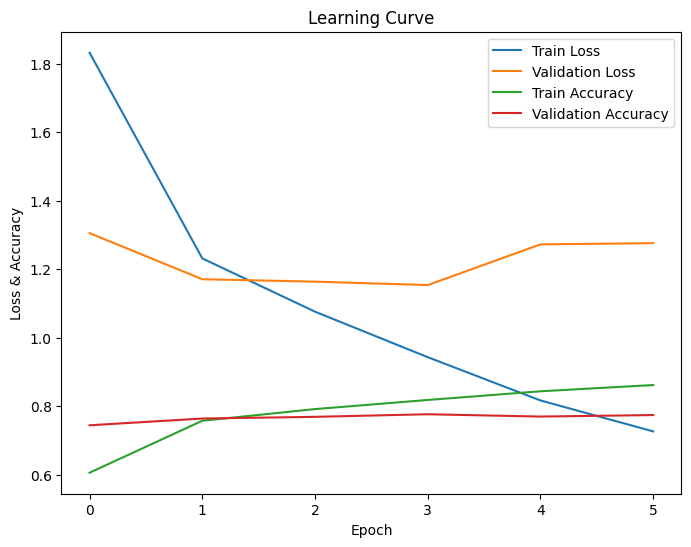

In [19]:
plot_learning_curve(metrics)

Evaluation: 100%|██████████| 121/121 [00:05<00:00, 22.07it/s]



================== SENTIMENT METRICS ==================
Accuracy: 0.7668
F1 Score: 0.7667
Precision: 0.7751
Recall: 0.7668

Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.76      0.71       486
     neutral       0.85      0.70      0.77       765
    positive       0.77      0.85      0.81       674

    accuracy                           0.77      1925
   macro avg       0.76      0.77      0.76      1925
weighted avg       0.78      0.77      0.77      1925


==================== TYPE METRICS ====================
Accuracy: 0.7605
F1 Score: 0.7583
Precision: 0.7635
Recall: 0.7605

Classification Report:
              precision    recall  f1-score   support

   emotional       0.83      0.85      0.84      1009
 informative       0.74      0.55      0.63       378
     opinion       0.63      0.75      0.68       377
 promotional       0.60      0.71      0.65        17
    question       0.71      0.72      0.71       144

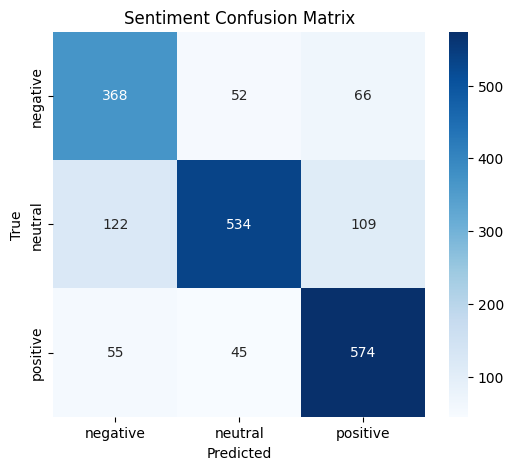

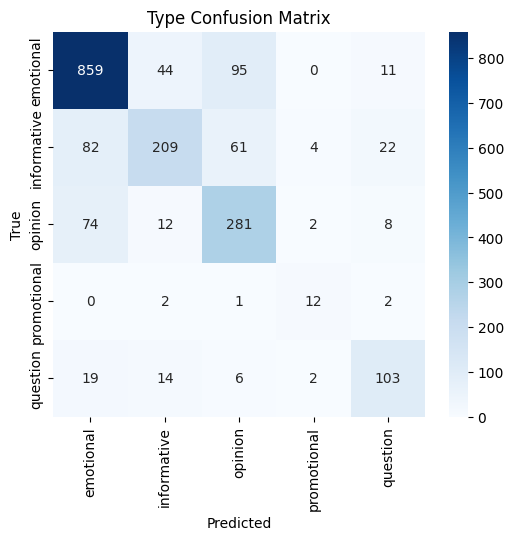

In [22]:
# evaluate on test dataset
evaluate_model(model, test_loader, sentiment_decoder, type_decoder, device=device, is_type=True)

Evaluation: 100%|██████████| 553/553 [00:30<00:00, 18.11it/s]


================== SENTIMENT METRICS ==================
Accuracy: 0.6514
F1 Score: 0.6482
Precision: 0.6482
Recall: 0.6514

Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.70      0.68      2992
     neutral       0.60      0.51      0.55      2784
    positive       0.69      0.73      0.71      3066

    accuracy                           0.65      8842
   macro avg       0.65      0.65      0.65      8842
weighted avg       0.65      0.65      0.65      8842



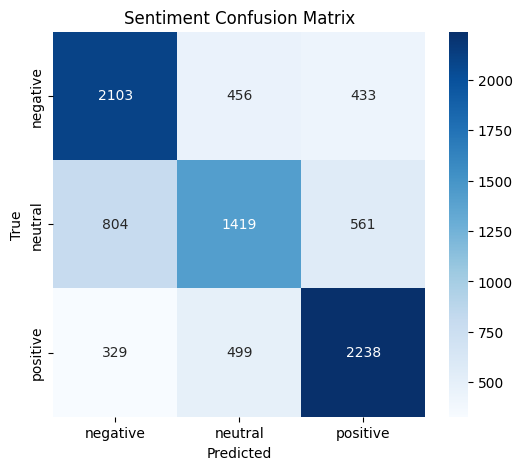

In [23]:
# evaluate on separate sentiment dataset
evaluate_model(model, sentiment_loader, sentiment_decoder, type_decoder, device=device, is_type=False)

In [29]:
def get_pred(model, x):
    # tokenize
    x = tokenizer(str(x), return_attention_mask=True, truncation=True, max_length=128, return_tensors=None)
    ids, a_m = x['input_ids'], x['attention_mask']

    # convert to tensors and move to device
    ids = torch.LongTensor([ids]).to(device)           # [1, seq_len]
    attention_mask = torch.LongTensor([a_m]).to(device)  # [1, seq_len]

    model.eval()
    with torch.no_grad():
        # use the tensor variable, not the original list
        y_sen, y_ty = model(ids, attention_mask)

    # get predicted class
    _, y_sen = torch.max(y_sen, 1)
    _, y_ty = torch.max(y_ty, 1)

    return y_sen.item(), y_ty.item()

i = random.randint(0, len(sentiment_x))
sentiment, type_ = get_pred(model, sentiment_x.iloc[i])
print(f"Comment: {sentiment_x.iloc[i]}")
print(f"Predicted sentiment: {sentiment_decoder.classes_[sentiment]}; Actual sentiment: {sentiment_decoder.classes_[test_y['sentiment'][i]]}")
print(f"Predicted Type: {type_decoder.classes_[type_]}; Actual Type: {type_decoder.classes_[test_y['type'][i]]}")

s = "ei movie amar ekdom valo lage na"
sentiment, type_ = get_pred(model, s)
print(f"Comment: {s}")
print(f"Predicted sentiment: {sentiment_decoder.classes_[sentiment]}")
print(f"Predicted Type: {type_decoder.classes_[type_]}")

Comment: common story
Predicted sentiment: neutral; Actual sentiment: positive
Predicted Type: informative; Actual Type: promotional
Comment: ei movie amar ekdom valo lage na
Predicted sentiment: negative
Predicted Type: opinion


In [30]:
summary(model)

Layer (type:depth-idx)                                            Param #
SentimentBERT                                                     --
├─XLMRobertaModel: 1-1                                            --
│    └─XLMRobertaEmbeddings: 2-1                                  --
│    │    └─Embedding: 3-1                                        192,001,536
│    │    └─Embedding: 3-2                                        394,752
│    │    └─Embedding: 3-3                                        768
│    │    └─LayerNorm: 3-4                                        1,536
│    │    └─Dropout: 3-5                                          --
│    └─XLMRobertaEncoder: 2-2                                     --
│    │    └─ModuleList: 3-6                                       85,054,464
│    └─XLMRobertaPooler: 2-3                                      --
│    │    └─Linear: 3-7                                           590,592
│    │    └─Tanh: 3-8                                             -

In [38]:
# save the trained model weights
path = "./models/bert"
os.mkdir(path)

model_path = os.path.join(path, 'model.safetensors')
save_file(model.state_dict(), model_path)

config = {
    "model_name": "xlm-roberta-base",
    "sentiment_out": 3,
    "type_out": 5,
    "dropout_rate": 0.5
}

with open(os.path.join(path, 'config.json'), 'w') as f:
    json.dump(config, f)

*****
## Load the train model and weights

In [41]:
with open('./models/bert/config.json', 'r') as f:
    config = json.load(f)

loaded_model = SentimentBERT(
    model=base_model,
    sentiment_out=config['sentiment_out'],
    type_out=config['type_out'],
    dropout_rate=config['dropout_rate']
)

state_dict = load_file('./models/bert/model.safetensors')

loaded_model.load_state_dict(state_dict)

loaded_model.to(device)
print("Model loaded from safetensors!")

Model loaded from safetensors!


In [52]:
summary(loaded_model)

Layer (type:depth-idx)                                            Param #
SentimentBERT                                                     --
├─XLMRobertaModel: 1-1                                            --
│    └─XLMRobertaEmbeddings: 2-1                                  --
│    │    └─Embedding: 3-1                                        192,001,536
│    │    └─Embedding: 3-2                                        394,752
│    │    └─Embedding: 3-3                                        768
│    │    └─LayerNorm: 3-4                                        1,536
│    │    └─Dropout: 3-5                                          --
│    └─XLMRobertaEncoder: 2-2                                     --
│    │    └─ModuleList: 3-6                                       85,054,464
│    └─XLMRobertaPooler: 2-3                                      --
│    │    └─Linear: 3-7                                           590,592
│    │    └─Tanh: 3-8                                             -

In [42]:
loaded_model

SentimentBERT(
  (model): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [49]:
def get_pred(model, x):
    s = x
    # tokenize
    x = tokenizer(str(x), return_attention_mask=True, truncation=True, max_length=128, return_tensors=None)
    ids, a_m = x['input_ids'], x['attention_mask']

    # convert to tensors and move to device
    ids = torch.LongTensor([ids]).to(device)           # [1, seq_len]
    attention_mask = torch.LongTensor([a_m]).to(device)  # [1, seq_len]

    model.eval()
    with torch.no_grad():
        # use the tensor variable, not the original list
        y_sen, y_ty = model(ids, attention_mask)

    # get predicted class
    _, y_sen = torch.max(y_sen, 1)
    _, y_ty = torch.max(y_ty, 1)

    print(f"Comment: {s}")
    print(f"\nPredicted sentiment: {sentiment_decoder.classes_[y_sen]}")
    print(f"Predicted Type: {type_decoder.classes_[y_ty]}")

s = "I litreally hate his videos"
get_pred(loaded_model, s)

Comment: I litreally hate his videos

Predicted sentiment: negative
Predicted Type: opinion
